In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.special import expi
from scipy.sparse.linalg import spsolve
from scipy.sparse import csc_matrix

In [2]:
import time

In [38]:
class ODEsolvers():
    '''
    a class containing solvers that solves for an euation of the form 
    d/dt(y) = f(y,t)
    '''
    def __init__(self, y_init, deltaTs, slope_func):
        '''
        initiate the object with the old value of y 
        y_init : initial values of the variable before simulation starts
        deltaTs: a list of deltaTs over which the new values for y are to be calculated
        f: is the function that provides the time derivative at each node 
        '''
        self.y_0 = y_init
        self.deltaTs = deltaTs
        self.slope = slope_func
        self.solutions={}
        
    def euler(self,y,t, dt,*pparams, **nparams):
        '''
        returns the increment to the parameter y 
        '''
        eulerstep = self.slope(y,t,*pparams,**nparams)*dt
        return(eulerstep)
    
    def rk2(self,y,t, dt,*pparams, **nparams):
        '''
        returns the increment to the parameter y 
        '''
        k1=dt*self.slope(y,t,*pparams,**nparams)
        k2=dt*self.slope(y+k1/2,t+dt/2,*pparams,**nparams)
        return k2
    
    def rk4(self,y,t, dt,*pparams, **nparams):
        '''
        returns the increment to the parameter y 
        '''
        k1=dt*self.slope(y,t,*pparams,**nparams)
        k2=dt*self.slope(y+k1/2,t+dt/2,*pparams,**nparams)
        k3=dt*self.slope(y+k2/2,t+dt/2,*pparams,**nparams)
        k4=dt*self.slope(y+k3,t+dt,*pparams,**nparams)
        return (k1+2*k2+2*k3+k4)/6
    
    def solver(self, *pparams, method='euler', **nparams):
        solution = []
        solution.append(list(self.y_0))
        
        match method:
            case 'euler':
                solver = self.euler
            case 'rk2':
                solver = self.rk2
            case 'rk4':
                solver = self.rk4
            case other:
                print('Not implemented, choosing rk4 instead.')
                solver = self.rk4
        #print(method)
        #print(type(solution), solution)
        y_now = self.y_0    # set y values ()
        for ti,dt in zip(self.ts, self.deltaTs):
            step = solver(y_now, ti, dt, *pparams, **nparams)
            y_next = y_now+step
            solution.append(y_next)
            y_now= y_next
        solution = np.array(solution)
        self.solutions[method]=solution   #storing all the result is making things slow
        return(solution[:,-1]) # returns cout over time
        #return(y_now)    
        

In [39]:
class CSTRModel(ODEsolvers):
    '''
    This class makes a Continuous-Stirred-Tank-Reactor model 
    and provides methods to perform time domain simulations on it 
    '''
    def __init__(self, tau=2, N=1, dt=3, Tmax=20, y_init='first',inj_prot=None):
        '''
        params:  make sure all the units are consistent
            tau : V/q time taken to replace the whole volume of the tank
            N : number of subtanks the whole volume is divided into.
            dt: time diff between each simulation step
            Tmax  : max simulation time 
            y_init : initial concentration of tracer in each spatial grid
                   : takes values {'first', 'empty', list }
                   : 'first' - case where first (0th) cell has a tracer conc
                   : 'empty' - case where the whole volume has 0 tracer conc
                   : list: list of tracer conc in each of the grid cell
            inj_protocol: injection protocol to use 
                   : takes values {'rect_1s', 'rect_2s', 'rect_3s', 
                                   'ramp_1s', 'ramp_2s', 'biphasic'}

        '''
        
        # set and initialize temporal parameters 
        self.dt = dt
        self.Tmax = Tmax
        self.Nt = int(Tmax/dt)  # number of grid elements on the time axis
        deltaTs = np.ones(self.Nt)*dt
        #time stamp after each time step
        ts = np.cumsum(deltaTs)# [sum(self.deltaTs[:i+1])for i in range(len(self.deltaTs))] 
        self.ts = ts# np.append(0,ts)
        
        # set and initialize spatial parameters 
        # set initial condition of concs before sim starts
        self.N = int(N)  #number of mixing tanks in series
        match y_init:    
            case 'first':
                y_init = np.zeros(self.N)
                y_init[0] = 1     # set the tracer concentration in first mixing tank to 1
                                  # every conc in all other tanks is 0
            case 'empty':
                y_init = np.zeros(int(self.N)) # there are no trancer conc anywhere else
            case other:
                y_init = y_init   # set the initial concentrations of tanks if its provided. 

        
        
        #initiate ODEsolver
        ODEsolvers.__init__(self, y_init=y_init,deltaTs=deltaTs, slope_func=self.cstr)
        
        # injection protocol. cinj stores the concentration of injection 
        # create a list of concs being injected at each time step
        self.make_injection_protocol(inj_prot)
        
        #print(self.ts,self.cinj)
        
        # store model parameters
        self.tau = tau   # physical model parameter
        self.nparams = {'tau': tau, 'N':N }

    def make_injection_protocol(self, protocol):
        match protocol:
            case 'rect_1s':
                self.inj_t = [0,1.,1.,2.,3.]
                self.inj_c = [1, 1, 0, 0, 0]
            case 'rect_2s':
                self.inj_t = [0,2.,2.,3.,4.]
                self.inj_c = [1, 1, 0, 0, 0]
            case 'rect_3s':
                self.inj_t = [0,3.,3.,4.,5.]
                self.inj_c = [1, 1, 0, 0, 0]
            case 'ramp_1s':
                self.inj_t = [0,1.,1.,2.,5.]
                self.inj_c = [0, 1, 0, 0, 0]
            case 'ramp_2s':
                self.inj_t = [0,2.,2.,3.,5.]
                self.inj_c = [0, 1, 0, 0, 0]
            case 'biphasic':
                self.inj_t = [  0,1.0,1.,2.,2.,3.,3.,4.]
                self.inj_c = [0.7,0.7,0., 0, 1,1,0,0]
            case None:
                self.inj_t = [0,1.]
                self.inj_c = [0, 0]
                
    def cinj(self, t):
        return(np.interp(t,self.inj_t, self.inj_c))

    def cstr(self, conc, ti, tau=2, N=1):
        '''
        this function provides the time derivative for the concentration 
        in a mixing tank at ti.
        CSTR time differencial
        f = d/dt(concentration) = slope = n/tau*(delta concentration)
            delta concentration in the equation above is the difference between 
            concentration in the nth tank and n-1th tank     
        input:
                conc : a numpy list of concentrat in n number of nodes at time step ti
                ti   : time at which the slope is being derived (note: in this model ti is not used)
                n    : number of tanks in series
                tau  : some parameter of the mixing tank (units = time)
                cinj : the concentration of the fluid being injected into the 0th mixing tank
                       at the ith time step.
        '''
        #print(ti, ts)
        Cinj_t = self.cinj(ti) # injection concentration at ti
        c = np.append(Cinj_t, conc)  # we append the injection
        slope = N/tau*(c[:-1]-c[1:])
        return(slope)

    def analytical(self, c0=1):
        ts = self.ts
        tau = self.tau
        match self.N:
            case 1:
                return c0*np.exp(-ts/tau)
            case 2:
                return 2*c0*ts/tau*np.exp(-2*ts/tau)
            case 3:
                return c0*9*ts*ts/2/tau/tau*np.exp(-3*ts/tau)
            case other:
                Print('Not implemented')
                return(None)

In [5]:
def comparision_plot(N,dt,ts,analitical, soln1, soln2, soln3):
    
    fig, axs=plt.subplots(nrows=2)
    
    ax=axs[0]
    ax.plot(ts, analitical,'-o',markersize=7, label='analytical')
    ax.plot(ts, soln1,'-*',markersize=7, label='numerical, euler')
    ax.plot(ts, soln2,'-*',markersize=5, label='numerical, rk2')
    ax.plot(ts, soln3,'-*',markersize=2, label='numerical, rk4')
    ax.set(xlabel='time ', ylabel='conc. at tank exit')
    ax.set(title = f'Change in exit conc over time,\n N of tank:{N}, deltaT: {dt}')
    ax.legend()
    
    ax=axs[1]
    #ax.plot(ts, analitical,'-o',markersize=7, label='analytical')
    ax.plot(ts, np.abs(soln1-analitical),'-*',markersize=7, label='numerical, euler')
    ax.plot(ts, np.abs(soln2-analitical),'-*',markersize=5, label='numerical, rk2')
    ax.plot(ts, np.abs(soln3-analitical),'-*',markersize=2, label='numerical, rk4')
    ax.set(xlabel='time ', ylabel='error', yscale='log')
    ax.set(title = f'Error,\n N of tank:{N}, deltaT: {dt}')
    ax.legend()
    plt.tight_layout()


In [6]:
def make(tau=2, N=1,dt=3,Tmax=20,y_init='first'):

    model = CSTRModel(tau=tau, N=N, dt=dt, Tmax=Tmax, y_init=y_init)
    nparams = model.nparams#

    soln1 =model.solver(**nparams)[1:]
    soln2 =model.solver(method='rk2',**nparams)[1:]
    soln3 =model.solver(method='rk4',**nparams)[1:]
    #print(soln1,soln2,soln3)
    ts=model.ts
    analitical= model.analytical()
    comparision_plot(N,dt,ts,analitical, soln1, soln2, soln3)

# Exercise 1: 

## Part 1
Implemented OED solver and made a CSRT model 

## Part 2

# Why is the error decreasing with time?? 

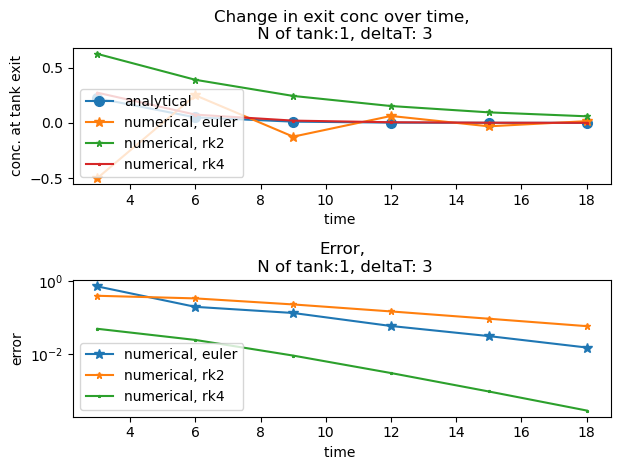

In [7]:
make(tau=2, N=1,dt=3,Tmax=20,y_init='first')

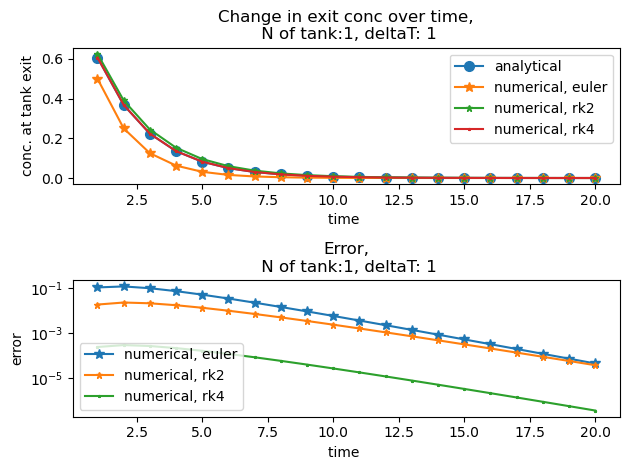

In [8]:
make(tau=2, N=1, dt=1, Tmax=20, y_init='first')

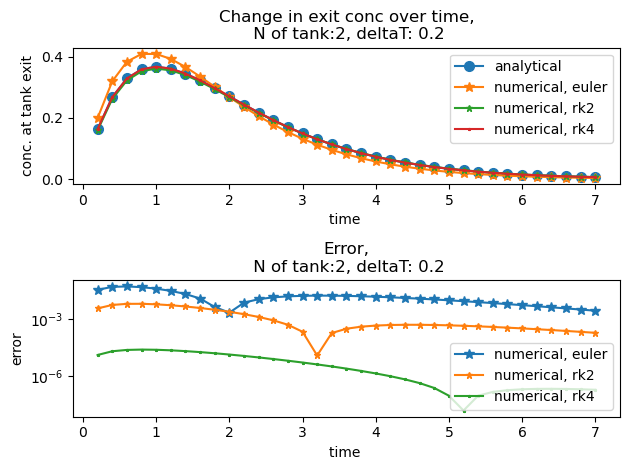

In [9]:
make(tau=2, y_init='first', dt=.2, Tmax=7, N=2)

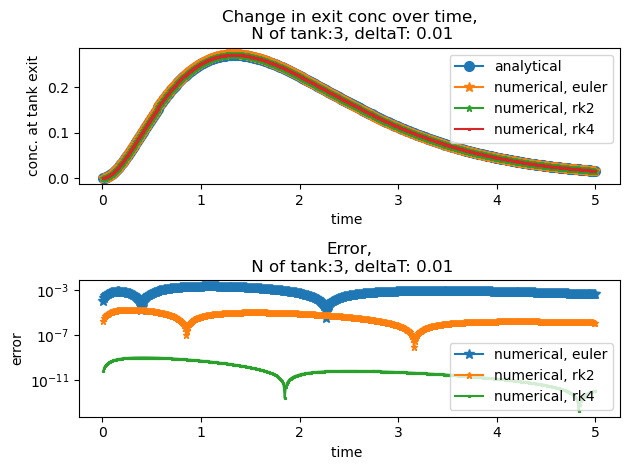

In [10]:
make(dt=.01, Tmax=5, N=3)

Error scaling

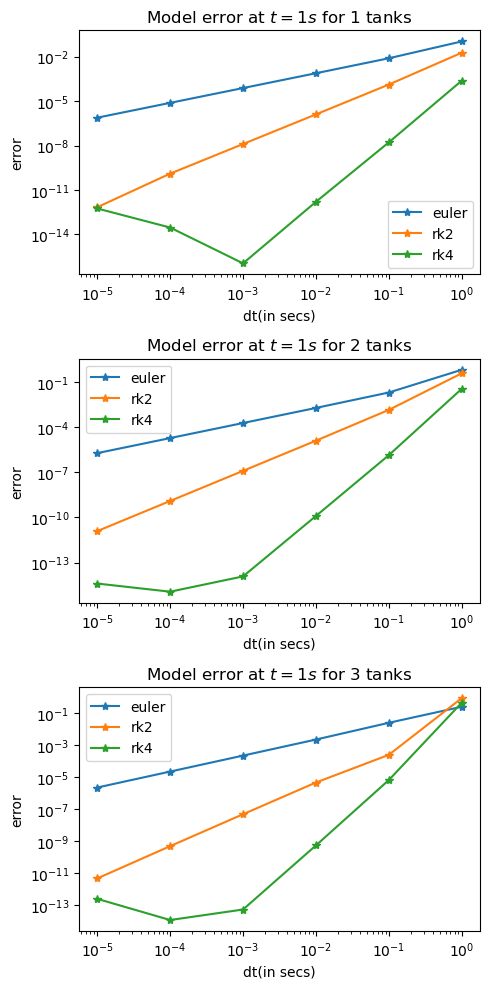

In [12]:
# parameters. do this for finer dt scaling
n = 5
tau = 2
N = 2
Tmax = 1
y_init = 'first'

# time deltas
dts = np.geomspace(1, 10**-n, n+1)
# print(dts)

# make the figure
fig, axs = plt.subplots(nrows = 3, figsize=(5,10))
for N, ax in zip([1,2,3], axs):    
    for method in ['euler', 'rk2', 'rk4']:
        error = []
        for dt in dts:
            model = CSTRModel(tau=tau, N=N, dt=dt, Tmax=Tmax, y_init=y_init)
            nparams = model.nparams
            soln1 = model.solver(method=method, **nparams)[-1]
            analytical = model.analytical()[-1]
            error.append(np.abs(soln1-analytical))
        ax.plot(dts, error,'-*' ,label=method)

        # print(method,error)
    ax.set(xlabel='dt(in secs)', ylabel='error',
           title=f'Model error at $t=1s$ for {N} tanks',
           xscale='log', yscale='log')
    ax.legend()
plt.tight_layout()

# Exercise 2: Fit CSTR model to CFD model: Healthy aorta
## part 1: Find the flow rate q

In [13]:
concdata = pd.read_csv('data/Healthy_rect_1s.csv')
dt = concdata.Time[1]-concdata.Time[0] # in seconds
dt =dt/60  # convert to mins
Minj = 83.333 #in grams
q = Minj/concdata.Concentration.sum()/dt
(f'Flow rate from healthy heart data: {q:0.2f} ml/min or {q/1000:0.2f}L/min')

'Flow rate from healthy heart data: 5005.98 ml/min or 5.01L/min'

## Part 2: Replicate injection protocols



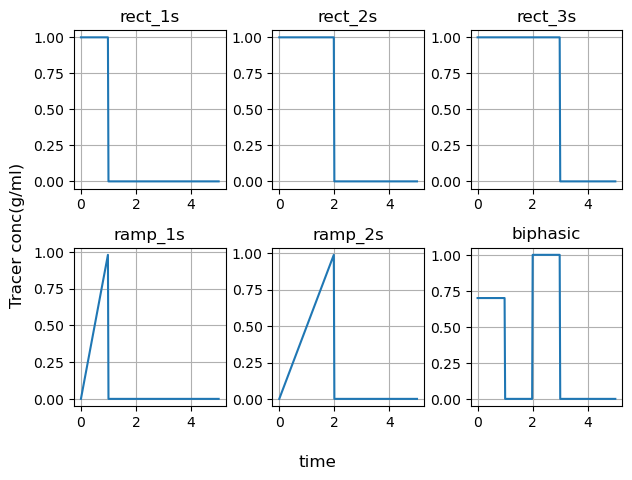

In [14]:
protocols = ['rect_1s', 'rect_2s', 'rect_3s', 'ramp_1s', 'ramp_2s', 'biphasic']
t = concdata.Time
Tmax = t.max()
dt = 0.02
fig, axs = plt.subplots(nrows = 2, ncols = 3)
axs = axs.flatten()
for ax, protocol in zip(axs, protocols):
    model = CSTRModel(dt=dt, Tmax=Tmax, inj_prot=protocol)
    c = model.cinj(t)  # injection concentrations
    ax.plot(t,c)
    ax.grid()
    ax.set_title(protocol)
fig.supylabel('Tracer conc(g/ml)')
fig.supxlabel('time')
plt.tight_layout()

## Part 3 Fit data

In [34]:
concdata

,Time,Concentration
0,0.00,0.000000e+00
1,0.02,0.000000e+00
2,0.04,0.000000e+00
3,0.06,0.000000e+00
4,0.08,0.000000e+00
...,...,...
246,4.92,8.620000e-06
247,4.94,4.980000e-06
248,4.96,2.020000e-06
249,4.98,2.510000e-08


In [54]:
def fit_func(t, tau, N):

    Tmax = t.max()
    dt = t[1]-t[0]
    method = 'euler'
    model = CSTRModel(tau=tau, N=N, Tmax=Tmax, dt=dt,
                      y_init='empty', inj_prot='rect_1s')
    nparams = {'N': N, 'tau': tau}
    soln3 = model.solver(method=method, **nparams)
    return(model.solutions[method][:, -1])

In [70]:
def plotcrap(tau = 2,N = 10):
    fig, ax = plt.subplots()
    t = concdata.Time
    y = concdata.Concentration
    
    Tmax = t.max()
    dt = t[1]-t[0]
    method = 'euler'
    model = CSTRModel(tau=tau, N=N, Tmax=Tmax, dt=dt,
                      y_init='empty', inj_prot='rect_1s')
    nparams = {'N': N, 'tau': tau}
    soln3 = model.solver(method=method, **nparams)
    model.solutions[method][:, -1]
    
    a = fit_func(t,tau, N)
    ax.plot(t,y, label='measured')
    ax.plot(t,a, label='modelled')
    
    ax.legend()

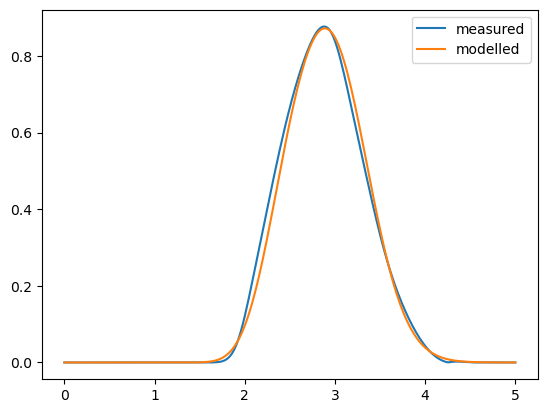

In [80]:
plotcrap(2.42,38)

# HOLY CRAP! hand fitting worked :)

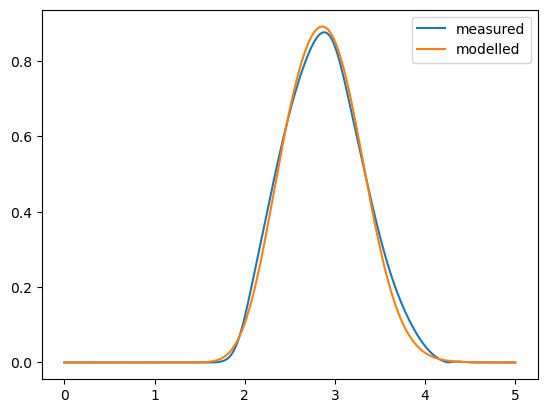

In [82]:
plotcrap(*popt)

### parameter optimixation using curve_fit is not working. 
using bounds option gives useless results at midpoint of the bounds. 

In [86]:
t = concdata.Time

dt = 0.02
xdata = t     # given a time discretization deltaTs
ydata = concdata.Concentration  # change re,pinit,k till you reach this value
# popt is the values of re,pinit,k reached
popt, pcov = curve_fit(fit_func, xdata, ydata)#, bounds=([0,0],[5,100]))#,maxfev = 80000, bounds=(0,[5,1000])) 
popt

ValueError: negative dimensions are not allowed